# Predicting Death Days from Laboratory Test Results

## Overview

In this analysis, we aim to predict the number of days until death based on standardized laboratory test results. The process involves standardizing the test results, merging with a target variable (days until death), and preparing the data for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df_labs = pd.read_csv('/home/amitdubey/cs229/Dataset/2025_05_27_PROACT_ALL_FORMS/PROACT_LABS.csv')
df_labs

,subject_id,Test_Name,Test_Result,Test_Unit,Laboratory_Delta
0,121,Phosphorus,6.19,mmol/L,0.0
1,121,AST(SGOT),14,U/L,0.0
2,121,Gamma-glutamyltransferase,25,U/L,0.0
3,121,Absolute Neutrophil Count,4.04,10E9/L,0.0
4,121,Chloride,107,mmol/L,0.0
...,...,...,...,...,...
2937157,999882,Basophils,1.6,%,253.0
2937158,999882,IMMUNOGLOBULIN A,252,mg/dL,253.0
2937159,999882,Segmented Neutrophils,54,%,253.0
2937160,999882,Glucose,7.7145,mmol/L,253.0


In [3]:
list[df_labs['Test_Name'].nunique()]

list[293]

Number of unique test names: 293


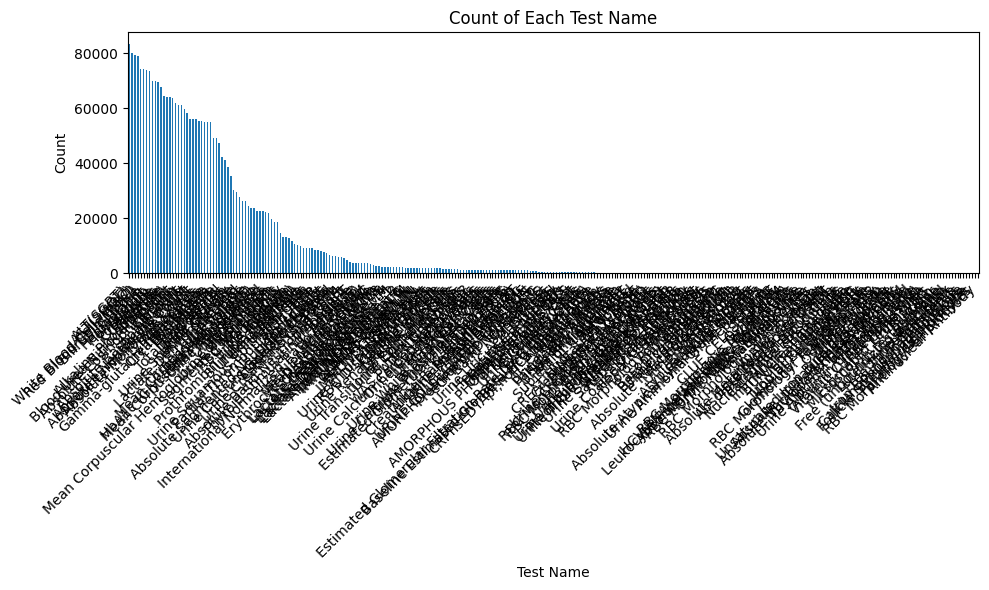

In [4]:
import matplotlib.pyplot as plt

# Count how many times each test name appears
test_counts = df_labs['Test_Name'].value_counts()

# Display the number of unique test names
print("Number of unique test names:", df_labs['Test_Name'].nunique())

# Plot the counts
plt.figure(figsize=(10, 6))
test_counts.plot(kind='bar')
plt.title('Count of Each Test Name')
plt.xlabel('Test Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
df_labs['Test_Name'].value_counts().mean()

np.float64(10024.443686006825)

In [6]:
df_labs['subject_id'].value_counts().count()

np.int64(10103)

In [7]:
df_labs['Laboratory_Delta'].value_counts()

Laboratory_Delta
 0.0       296756
 28.0       34137
 14.0       29363
 29.0       24651
 42.0       24610
            ...  
 1322.0         2
 1253.0         2
-260.0          1
 1954.0         1
-350.0          1
Name: count, Length: 1376, dtype: int64

In [8]:
df_labs['Laboratory_Delta'].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

count    2.925286e+06
mean     1.784175e+02
std      1.857478e+02
min     -4.680000e+02
1%      -1.000000e+01
5%       0.000000e+00
25%      3.800000e+01
50%      1.240000e+02
75%      2.710000e+02
95%      5.020000e+02
99%      8.020000e+02
max      3.742000e+03
Name: Laboratory_Delta, dtype: float64

In [9]:
test_counts = df_labs['Test_Name'].value_counts()
val = np.arange(500, 10000, 500)  # thresholds

for v in val:
    high_count_tests = test_counts[test_counts > v]  # filter tests with count > v
    print(f"Number of tests with count > {v}: {len(high_count_tests)}")


Number of tests with count > 500: 150
Number of tests with count > 1000: 138
Number of tests with count > 1500: 114
Number of tests with count > 2000: 95
Number of tests with count > 2500: 87
Number of tests with count > 3000: 85
Number of tests with count > 3500: 83
Number of tests with count > 4000: 77
Number of tests with count > 4500: 76
Number of tests with count > 5000: 76
Number of tests with count > 5500: 75
Number of tests with count > 6000: 74
Number of tests with count > 6500: 70
Number of tests with count > 7000: 69
Number of tests with count > 7500: 68
Number of tests with count > 8000: 67
Number of tests with count > 8500: 64
Number of tests with count > 9000: 64
Number of tests with count > 9500: 60


In [10]:
# =============================================================================
# ENHANCED LAB SELECTION (Anchors + Frequency) → Builds df_wide
# =============================================================================

import re, numpy as np, pandas as pd

# 1. Extended clinically important anchor tests
anchor_tests_raw = [
    # Lipids / metabolic
    'Cholesterol', 'Total Cholesterol', 'LDL', 'LDL Cholesterol', 'HDL', 'HDL Cholesterol', 'Triglycerides', 'Triglyceride',
    # Glucose control
    'Glucose', 'HbA1c',
    # Renal / muscle
    'Creatinine', 'BUN', 'eGFR', 'Uric Acid', 'UricAcid', 'CK', 'CK Total', 'CK-Total',
    # Liver
    'ALT(SGPT)', 'AST(SGOT)', 'Alkaline Phosphatase', 'Bilirubin (Total)', 'Albumin', 'Total Protein',
    # Hematology
    'White Blood Cell (WBC)', 'Red Blood Cells (RBC)', 'Hemoglobin', 'Hematocrit', 'Platelets', 'RDW', 'MCV', 'MCH', 'MCHC',
    # Inflammation / immune
    'CRP', 'ESR', 'Ferritin', 'LDH',
    # Electrolytes / minerals
    'Sodium', 'Potassium', 'Chloride', 'Calcium', 'Phosphorus', 'Phosphate', 'Magnesium', 'Bicarbonate', 'CO2', 'Anion Gap',
    # Endocrine / nutrition
    'TSH', 'Free T4', 'Vitamin D', 'Vit D', 'Vitamin B12', 'Folate', 'Prealbumin'
]

# 2. Normalize names
def normalize(name: str) -> str:
    if pd.isna(name):
        return 'unknown'
    s = str(name).lower().strip()
    replacements = {
        'total cholesterol':'cholesterol_total',
        'cholesterol':'cholesterol_total',
        'hdl cholesterol':'hdl',
        'ldl cholesterol':'ldl',
        'triglyceride':'triglycerides',
        'uricacid':'uric acid',
        'alt(sgpt)':'alt',
        'ast(sgot)':'ast',
        'alkaline phosphatase':'alk phos',
        'bilirubin (total)':'bilirubin',
        'white blood cell (wbc)':'wbc',
        'red blood cells (rbc)':'rbc',
        'vit d':'vitamin d',
        'ck total':'ck',
        'ck-total':'ck',
        'egfr':'egfr'
    }
    return replacements.get(s, s)

df_labs['Test_Name_Normalized'] = df_labs['Test_Name'].apply(normalize)

# 3. Build anchor set (normalized)
anchor_norm = sorted({normalize(a) for a in anchor_tests_raw})

# 4. Frequency counts (normalized)
norm_counts = df_labs['Test_Name_Normalized'].value_counts()

present_anchors = [a for a in anchor_norm if a in norm_counts.index]
missing_anchors = [a for a in anchor_norm if a not in norm_counts.index]

print(f"Anchors present: {len(present_anchors)}")
print(f"Anchors missing: {len(missing_anchors)}")

# 5. Frequency threshold (keep high freq OR anchor)
FREQ_THRESHOLD = 5000   # adjust if needed
high_freq = [t for t, c in norm_counts.items() if c >= FREQ_THRESHOLD]

selected_tests = sorted(set(high_freq).union(anchor_norm))
print(f"High-frequency (≥{FREQ_THRESHOLD}): {len(high_freq)}")
print(f"Total selected after adding anchors: {len(selected_tests)}")

# 6. Map Laboratory_Delta → time periods (same logic as original)
def map_laboratory_delta(delta):
    if pd.isna(delta): return 'missing'
    if delta < 0: return 'before_baseline'
    if delta == 0: return '0_baseline'
    if 1 <= delta <= 35: return '1_month'
    if 36 <= delta <= 110: return '3_months'
    if 111 <= delta <= 200: return '6_months'
    if 201 <= delta <= 380: return '1_year'
    return 'other'

df_labs['time_period'] = df_labs['Laboratory_Delta'].apply(map_laboratory_delta)
valid_periods = ['before_baseline','0_baseline','1_month','3_months','6_months','1_year']

# 7. Filter rows
df_sel = df_labs[
    (df_labs['Test_Name_Normalized'].isin(selected_tests)) &
    (df_labs['time_period'].isin(valid_periods))
].copy()

# 8. Numeric conversion
df_sel['Test_Result'] = pd.to_numeric(df_sel['Test_Result'], errors='coerce')

# 9. Aggregate (median per subject/test/time)
agg = (df_sel
       .groupby(['subject_id','Test_Name_Normalized','time_period'], as_index=False)
       .agg({'Test_Result':'median','Test_Unit':'first'}))

# 10. Pivot to wide
agg['column_name'] = agg['Test_Name_Normalized'] + '_' + agg['time_period']
df_wide = agg.pivot(index='subject_id', columns='column_name', values='Test_Result').reset_index()

# 11. Ensure full matrix (all selected × all periods)
time_order = ['before_baseline','0_baseline','1_month','3_months','6_months','1_year']
expected_columns = ['subject_id']
for t in selected_tests:
    for tp in time_order:
        expected_columns.append(f"{t}_{tp}")

df_wide = df_wide.reindex(columns=expected_columns, fill_value=np.nan)

print(f"Unified lab matrix: {df_wide.shape[0]:,} subjects × {df_wide.shape[1]-1:,} features")
print(f"Anchor tests forced in: {present_anchors[:15]}{' ...' if len(present_anchors)>15 else ''}")

# 12. Anchor feature list (for optional weighting later)
anchor_flag_cols = [c for c in df_wide.columns if any(c.startswith(a + '_') for a in anchor_norm)]
print(f"Anchor feature columns retained: {len(anchor_flag_cols)}")

# (Downstream cells can proceed unchanged: df_wide → cleaning → clipping → scaling → df_baseline)

Anchors present: 31
Anchors missing: 15
High-frequency (≥5000): 75
Total selected after adding anchors: 97
Unified lab matrix: 10,079 subjects × 582 features
Anchor tests forced in: ['albumin', 'alk phos', 'alt', 'anion gap', 'ast', 'bicarbonate', 'bilirubin', 'calcium', 'chloride', 'cholesterol_total', 'creatinine', 'ferritin', 'folate', 'free t4', 'glucose'] ...
Anchor feature columns retained: 276


## Selection of High-Frequency Laboratory Tests

In large-scale clinical datasets, laboratory tests are often performed with widely varying frequencies. Some tests are ordered routinely, while others are rare or specialized. To focus the analysis on the most representative and impactful data, it is useful to filter tests based on their occurrence counts.

In this study, we chose to consider only those tests that were performed more than **6,500 times**. This threshold ensures that the analysis emphasizes tests with sufficient sample size, which increases the reliability of any statistical insights derived from the data. Tests with very low counts are often excluded because they may not provide statistically meaningful patterns and can introduce noise.

By applying this frequency-based selection, we can:

- Concentrate on commonly performed tests that are most relevant for clinical decision-making.
- Reduce the effect of outliers or extremely rare tests on overall analysis.
- Improve the robustness and interpretability of downstream statistical analyses and visualizations.

This approach is particularly important when dealing with high-dimensional laboratory datasets, where the inclusion of rare tests could obscure trends in the more frequently observed tests.


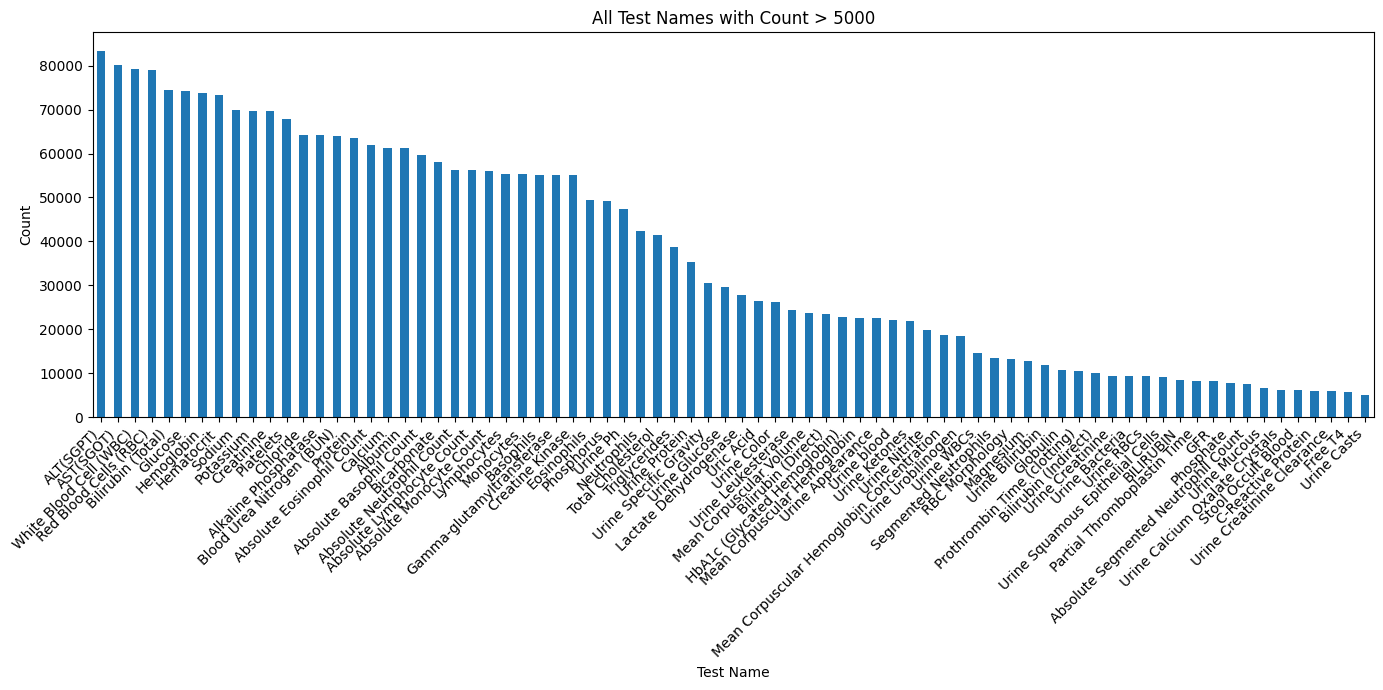

Number of tests with count > 5000: 76


In [11]:
import matplotlib.pyplot as plt

# Count each test name
test_counts = df_labs['Test_Name'].value_counts()

# Filter tests that appear more than 7000 times
high_count_tests = test_counts[test_counts > 5000]

# Plot ALL tests above that threshold
plt.figure(figsize=(14, 7))
high_count_tests.plot(kind='bar')
plt.title('All Test Names with Count > 5000')
plt.xlabel('Test Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Number of tests with count > 5000:", len(high_count_tests))


In [13]:
test_counts.head(76)  # Top 20 most frequent tests

Test_Name
ALT(SGPT)                     83414
AST(SGOT)                     80081
White Blood Cell (WBC)        79199
Red Blood Cells (RBC)         79029
Bilirubin (Total)             74428
                              ...  
Stool Occult Blood             6154
C-Reactive Protein             6029
Urine Creatinine Clearance     6011
Free T4                        5689
Urine Casts                    5022
Name: count, Length: 76, dtype: int64

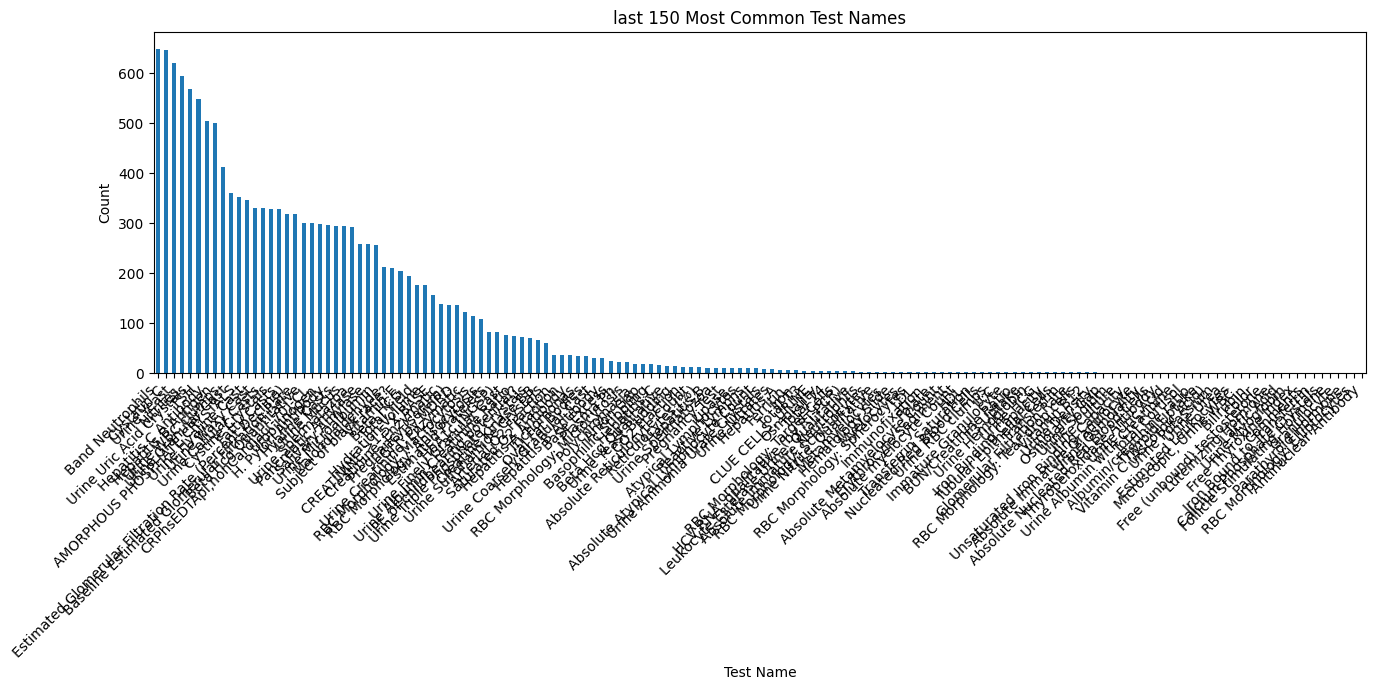

In [14]:
import matplotlib.pyplot as plt

test_counts = df_labs['Test_Name'].value_counts()

plt.figure(figsize=(14, 7))
test_counts.tail(150).plot(kind='bar')
plt.title('last 150 Most Common Test Names')
plt.xlabel('Test Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
df_labs

,subject_id,Test_Name,Test_Result,Test_Unit,Laboratory_Delta,Test_Name_Normalized,time_period
0,121,Phosphorus,6.19,mmol/L,0.0,phosphorus,0_baseline
1,121,AST(SGOT),14,U/L,0.0,ast,0_baseline
2,121,Gamma-glutamyltransferase,25,U/L,0.0,gamma-glutamyltransferase,0_baseline
3,121,Absolute Neutrophil Count,4.04,10E9/L,0.0,absolute neutrophil count,0_baseline
4,121,Chloride,107,mmol/L,0.0,chloride,0_baseline
...,...,...,...,...,...,...,...
2937157,999882,Basophils,1.6,%,253.0,basophils,1_year
2937158,999882,IMMUNOGLOBULIN A,252,mg/dL,253.0,immunoglobulin a,1_year
2937159,999882,Segmented Neutrophils,54,%,253.0,segmented neutrophils,1_year
2937160,999882,Glucose,7.7145,mmol/L,253.0,glucose,1_year


## 5. Map Laboratory Delta to Time Periods

Define a function to categorize the laboratory delta into time periods.

## 12. Data Cleaning

Clean the DataFrame by removing columns with excessive missing values.

In [16]:
threshold = 6000
cols_to_keep = ['subject_id'] + [col for col in df_wide.columns 
                                  if col != 'subject_id' and df_wide[col].isnull().sum() <= threshold]

df_wide = df_wide[cols_to_keep]
df_wide.columns = df_wide.columns.str.strip()

surviving_tests = set()
for col in df_wide.columns:
    if col != 'subject_id':
        for time_period in ['before_baseline', '0_baseline', '1_month', '3_months', '6_months', '1_year']:
            if col.endswith(f'_{time_period}'):
                test_name = col.replace(f'_{time_period}', '')
                surviving_tests.add(test_name)
                break

surviving_tests = sorted(surviving_tests)
time_order = ['before_baseline', '0_baseline', '1_month', '3_months', '6_months', '1_year']

complete_columns = ['subject_id']
for test in surviving_tests:
    for time in time_order:
        complete_columns.append(f"{test}_{time}")

df_wide = df_wide.reindex(columns=complete_columns, fill_value=np.nan)

print(f"After cleaning: {df_wide.shape}")

After cleaning: (10079, 199)


In [17]:
df_wide.skew()

column_name
subject_id                                  0.027021
absolute basophil count_before_baseline          NaN
absolute basophil count_0_baseline          2.372618
absolute basophil count_1_month            16.141935
absolute basophil count_3_months           20.222874
                                             ...    
wbc_0_baseline                              2.548201
wbc_1_month                                 0.922901
wbc_3_months                                1.033120
wbc_6_months                                1.194127
wbc_1_year                                  2.105145
Length: 199, dtype: float64

## 13. Standardizing Skewed Lab Data with Outliers

In our lab dataset, some measurements (ALT, AST, Sodium, WBC, etc.) are highly skewed and contain extreme outliers. Using StandardScaler directly can be dominated by these outliers, while RobustScaler compresses small-range differences.

To balance preserving small differences and handling extreme outliers, we apply the following strategy:

- Clip extreme values using the 1st and 99th percentiles.
- Standardize the data using StandardScaler.

In [18]:
from sklearn.preprocessing import StandardScaler

df_scaled = df_wide.copy()
test_columns = [col for col in df_scaled.columns if col != 'subject_id']

for col in test_columns:
    if df_scaled[col].notna().sum() > 0:
        lower = df_scaled[col].quantile(0.01)
        upper = df_scaled[col].quantile(0.99)
        df_scaled[col] = df_scaled[col].clip(lower, upper)

scaler = StandardScaler()
df_scaled[test_columns] = scaler.fit_transform(df_scaled[test_columns])

print(f"Scaled {len(test_columns)} features")

Scaled 198 features


/home/amitdubey/.local/lib/python3.13/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/amitdubey/.local/lib/python3.13/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/amitdubey/.local/lib/python3.13/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [19]:
time_order = ['before_baseline', '0_baseline', '1_month', '3_months', '6_months', '1_year']

selected_cols = [col for col in df_scaled.columns if col.endswith('_0_baseline')]
df_baseline = df_scaled[['subject_id'] + selected_cols].copy()
df_baseline.rename(columns=lambda x: x.replace('_0_baseline', '') if x != 'subject_id' else x, inplace=True)

baseline_tests = sorted([col for col in df_baseline.columns if col != 'subject_id'])
expected_cols = ['subject_id'] + baseline_tests

def extract_timepoint(df_source, time_suffix, expected_columns):
    selected = [col for col in df_source.columns if col.endswith(f'_{time_suffix}')]
    df_temp = df_source[['subject_id'] + selected].copy()
    df_temp.rename(columns=lambda x: x.replace(f'_{time_suffix}', '') if x != 'subject_id' else x, inplace=True)
    df_temp = df_temp.reindex(columns=expected_columns, fill_value=np.nan)
    return df_temp

df_month = extract_timepoint(df_scaled, '1_month', expected_cols)
df_3month = extract_timepoint(df_scaled, '3_months', expected_cols)
df_6month = extract_timepoint(df_scaled, '6_months', expected_cols)
df_1year = extract_timepoint(df_scaled, '1_year', expected_cols)

all_dfs = [df_baseline, df_month, df_3month, df_6month, df_1year]
shapes = [df.shape for df in all_dfs]
all_same = len(set(shapes)) == 1

print(f"Alignment: {'✅ Success' if all_same else '⚠️ Mismatch'} - Shape: {shapes[0]}")

Alignment: ✅ Success - Shape: (10079, 34)


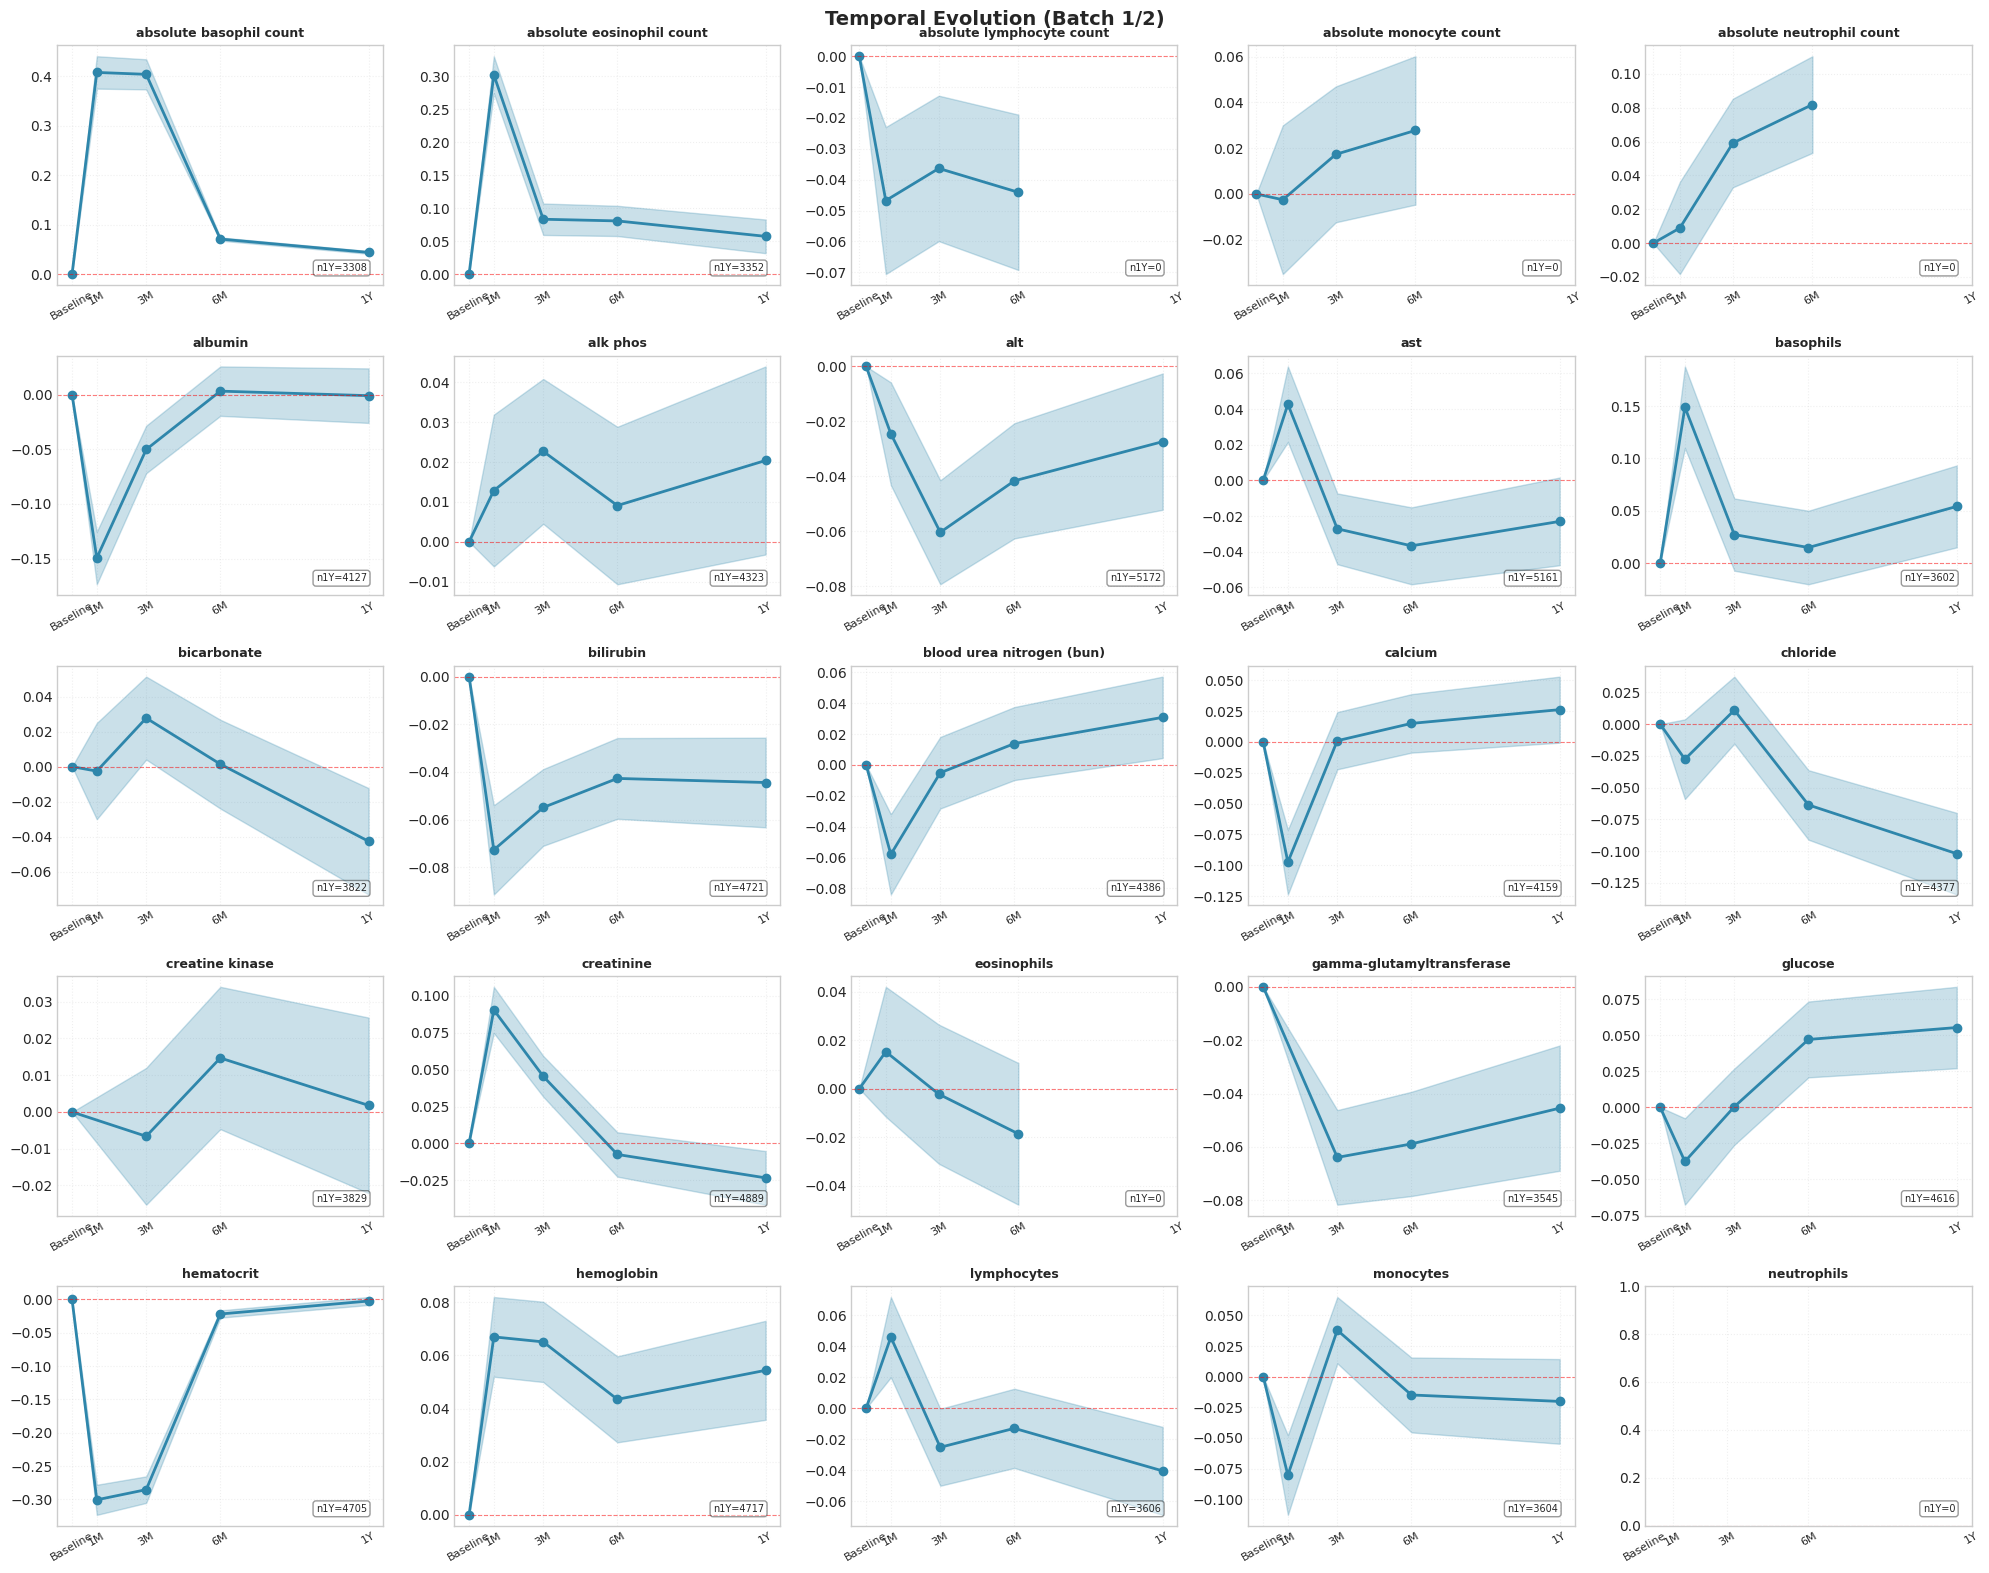

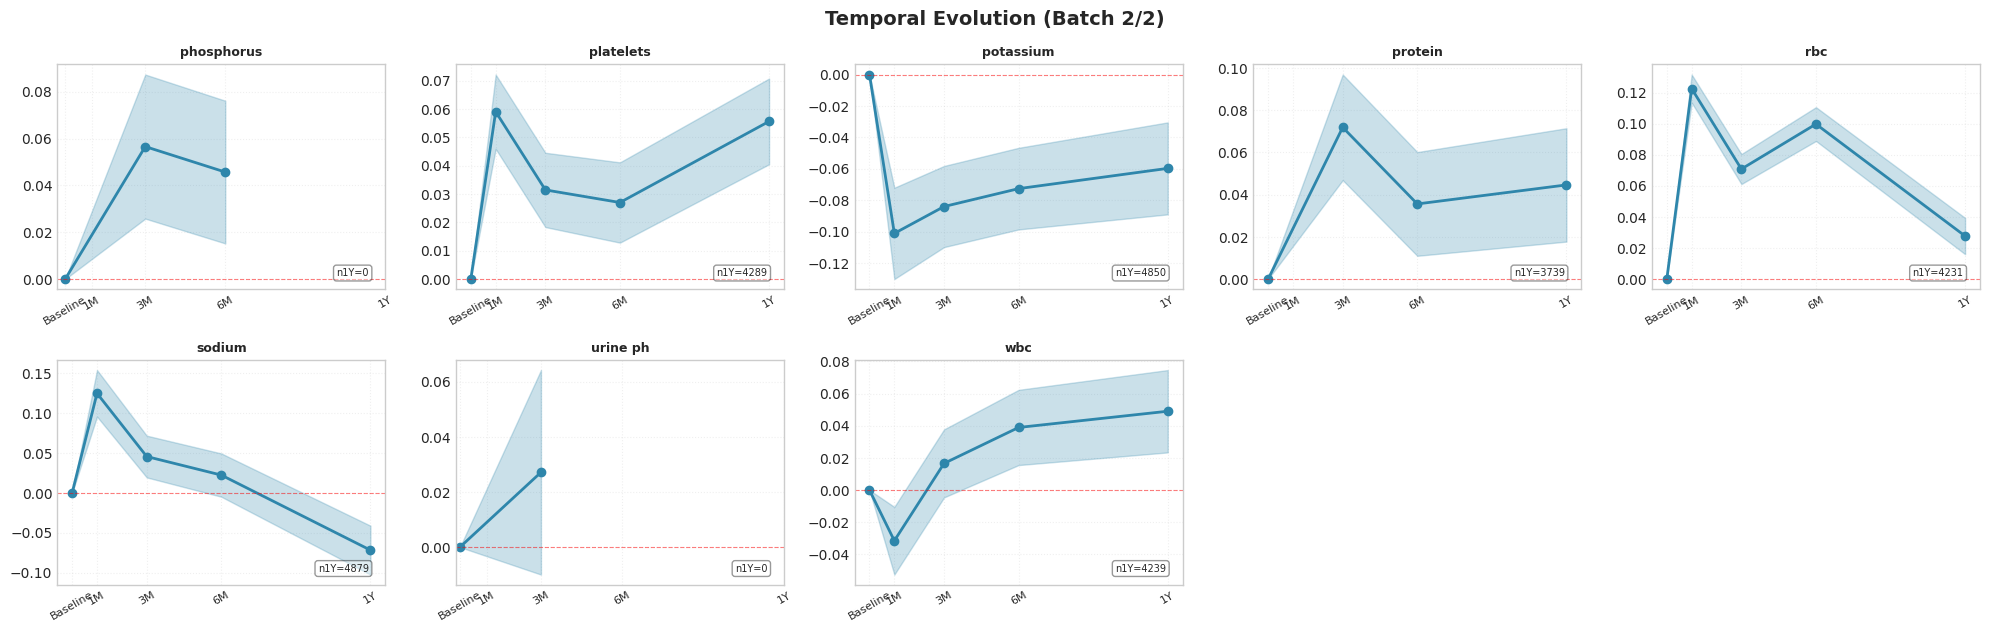

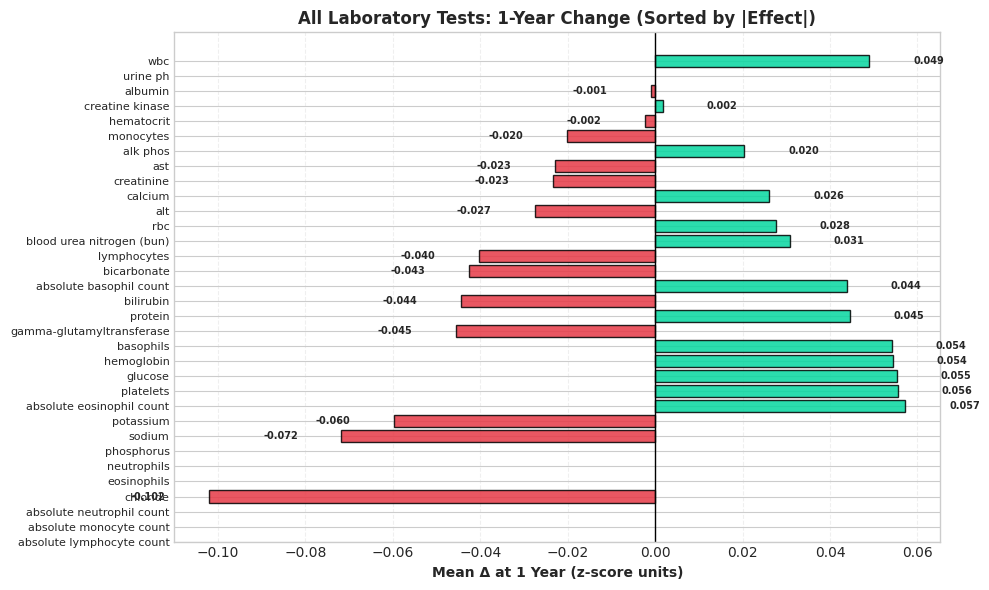

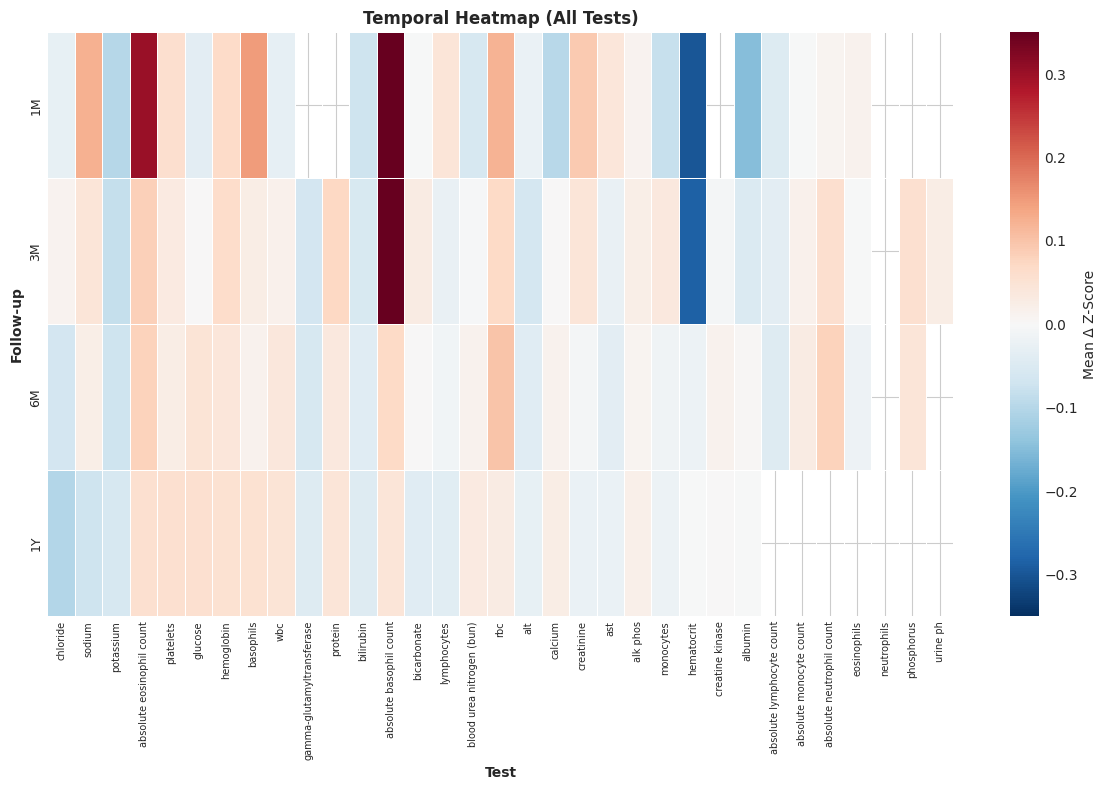

FULL SUMMARY (All Tests) - First 50 Rows
                     Test  MeanΔ_1M  MeanΔ_3M  MeanΔ_6M  MeanΔ_1Y  N_1Y
  absolute basophil count  0.407702  0.403873  0.070854  0.043836  3308
absolute eosinophil count  0.302393  0.083214  0.080668  0.057250  3352
absolute lymphocyte count -0.046749 -0.036336 -0.044075       NaN     0
  absolute monocyte count -0.002537  0.017319  0.027778       NaN     0
absolute neutrophil count  0.008931  0.059168  0.081895       NaN     0
                  albumin -0.149549 -0.050251  0.003112 -0.001023  4127
                 alk phos  0.012867  0.022693  0.009108  0.020412  4323
                      alt -0.024509 -0.060393 -0.041649 -0.027388  5172
                      ast  0.042723 -0.027158 -0.036707 -0.022995  5161
                basophils  0.148971  0.027255  0.014885  0.054177  3602
              bicarbonate -0.002565  0.027765  0.001429 -0.042679  3822
                bilirubin -0.072726 -0.054925 -0.042735 -0.044451  4721
blood urea nitrogen (bu

In [28]:
# =============================================================================
# VISUALIZATION SUITE (ALL TESTS, NOT JUST TOP) - BATCHED
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.style.use('seaborn-v0_8-whitegrid')

def align_pair(df1, df2):
    a = df1.set_index('subject_id').sort_index()
    b = df2.set_index('subject_id').sort_index()
    common_ids = a.index.intersection(b.index)
    common_cols = sorted(set(a.columns) & set(b.columns))
    return a.loc[common_ids, common_cols], b.loc[common_ids, common_cols]

# Deltas (reuse baseline + followups already built)
base_1m_a, base_1m_b = align_pair(df_baseline, df_month);    delta_1m = base_1m_b - base_1m_a
base_3m_a, base_3m_b = align_pair(df_baseline, df_3month);   delta_3m = base_3m_b - base_3m_a
base_6m_a, base_6m_b = align_pair(df_baseline, df_6month);   delta_6m = base_6m_b - base_6m_a
base_1y_a, base_1y_b = align_pair(df_baseline, df_1year);    delta_1y = base_1y_b - base_1y_a

all_tests = sorted([c for c in df_baseline.columns if c != 'subject_id'])
time_points = [0, 1, 3, 6, 12]
time_labels = ['Baseline','1M','3M','6M','1Y']

# Helper to collect mean ± sem across time for a test
def collect_series(test):
    means = [0]  # baseline z-score reference
    sems  = [0]
    for d in (delta_1m, delta_3m, delta_6m, delta_1y):
        if test in d.columns:
            means.append(d[test].mean())
            sems.append(d[test].sem())
        else:
            means.append(np.nan)
            sems.append(np.nan)
    return np.array(means), np.array(sems)

# =========================
# FIGURE 1 (ALL TESTS GRID)
# =========================
batch_size = 25  # number of tests per figure grid
n_batches = int(np.ceil(len(all_tests)/batch_size))
for b in range(n_batches):
    subset = all_tests[b*batch_size:(b+1)*batch_size]
    n = len(subset)
    cols = 5
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.2*rows))
    axes = np.array(axes).reshape(-1)
    for i, test in enumerate(subset):
        ax = axes[i]
        means, sems = collect_series(test)
        valid = ~np.isnan(means)
        if valid.sum() > 1:
            ax.plot(np.array(time_points)[valid], means[valid], 'o-', color='#2E86AB', linewidth=2)
            ax.fill_between(np.array(time_points)[valid],
                            (means - 1.96*sems)[valid],
                            (means + 1.96*sems)[valid],
                            color='#2E86AB', alpha=0.25)
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.set_title(test, fontsize=9, fontweight='bold')
        ax.set_xticks(time_points)
        ax.set_xticklabels(time_labels, rotation=30, fontsize=8)
        ax.grid(alpha=0.3, linestyle=':')
        # sample size at 1Y
        n1y = delta_1y[test].notna().sum() if test in delta_1y.columns else 0
        ax.text(0.95, 0.05, f"n1Y={n1y}", transform=ax.transAxes,
                ha='right', va='bottom', fontsize=7,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.4))
    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    fig.suptitle(f"Temporal Evolution (Batch {b+1}/{n_batches})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# =========================
# FIGURE 2 (BAR: 1Y CHANGE)
# =========================
one_year_stats = []
for test in all_tests:
    if test in delta_1y.columns:
        m = delta_1y[test].mean()
        one_year_stats.append((test, m))
one_year_stats.sort(key=lambda x: abs(x[1]), reverse=True)

tests_sorted = [t for t,_ in one_year_stats]
vals_sorted  = [v for _,v in one_year_stats]
colors = ['#E63946' if v < 0 else '#06D6A0' for v in vals_sorted]

fig, ax = plt.subplots(figsize=(10, max(6, len(tests_sorted)*0.18)))
ypos = np.arange(len(tests_sorted))
ax.barh(ypos, vals_sorted, color=colors, edgecolor='black', alpha=0.85)
ax.axvline(0, color='black', linewidth=1)
for y, v in zip(ypos, vals_sorted):
    ax.text(v + (0.01 if v>=0 else -0.01), y, f"{v:.3f}",
            va='center', ha='left' if v>=0 else 'right', fontsize=7, fontweight='bold')
ax.set_yticks(ypos)
ax.set_yticklabels(tests_sorted, fontsize=8)
ax.set_xlabel("Mean Δ at 1 Year (z-score units)", fontweight='bold')
ax.set_title("All Laboratory Tests: 1-Year Change (Sorted by |Effect|)", fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# =========================
# FIGURE 3 (HEATMAP ALL)
# =========================
heat_df = pd.DataFrame({
    '1M':   [delta_1m[t].mean() if t in delta_1m.columns else np.nan for t in all_tests],
    '3M':   [delta_3m[t].mean() if t in delta_3m.columns else np.nan for t in all_tests],
    '6M':   [delta_6m[t].mean() if t in delta_6m.columns else np.nan for t in all_tests],
    '1Y':   [delta_1y[t].mean() if t in delta_1y.columns else np.nan for t in all_tests]
}, index=all_tests)

# Sort by 1Y absolute change
heat_df = heat_df.reindex(heat_df['1Y'].abs().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(12, max(8, len(heat_df)/6)))
sns.heatmap(heat_df.T, cmap='RdBu_r', center=0, linewidths=0.6,
            linecolor='white', cbar_kws={'label':'Mean Δ Z-Score'}, ax=ax,
            vmin=-0.35, vmax=0.35)
ax.set_title("Temporal Heatmap (All Tests)", fontweight='bold')
ax.set_xlabel("Test", fontweight='bold')
ax.set_ylabel("Follow-up", fontweight='bold')
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# =========================
# SUMMARY TABLE (ALL)
# =========================
summary_table = pd.DataFrame({
    'Test': all_tests,
    'MeanΔ_1M': [delta_1m[t].mean() if t in delta_1m.columns else np.nan for t in all_tests],
    'MeanΔ_3M': [delta_3m[t].mean() if t in delta_3m.columns else np.nan for t in all_tests],
    'MeanΔ_6M': [delta_6m[t].mean() if t in delta_6m.columns else np.nan for t in all_tests],
    'MeanΔ_1Y': [delta_1y[t].mean() if t in delta_1y.columns else np.nan for t in all_tests],
    'N_1Y':     [delta_1y[t].notna().sum() if t in delta_1y.columns else 0 for t in all_tests]
})
print("="*120)
print("FULL SUMMARY (All Tests) - First 50 Rows")
print("="*120)
print(summary_table.head(50).to_string(index=False))
print(f"... total rows: {len(summary_table)}")
print("Δ = mean change from baseline (z-score units)")
# (You can save: summary_table.to_csv('lab_full_summary.csv', index=False))
# =============================================================================

In [21]:
# =============================================================================
# CALCULATE P-VALUES FOR LAB CHANGES (FIXED VERSION)
# =============================================================================

from scipy import stats
import pandas as pd
import numpy as np

def calculate_pvalue_for_change(baseline_data, followup_data, test_name):
    """
    Perform paired t-test to see if change is statistically significant
    """
    # Check if test exists in BOTH dataframes
    if test_name not in baseline_data.columns:
        return np.nan, np.nan, 0
    if test_name not in followup_data.columns:
        return np.nan, np.nan, 0
    
    # Align subjects (paired data)
    baseline = baseline_data.set_index('subject_id')[test_name]
    followup = followup_data.set_index('subject_id')[test_name]
    
    # Get common subjects with valid data at both timepoints
    common_ids = baseline.index.intersection(followup.index)
    
    if len(common_ids) == 0:
        return np.nan, np.nan, 0
    
    baseline_paired = baseline.loc[common_ids].dropna()
    followup_paired = followup.loc[common_ids].dropna()
    
    # Only use subjects with data at both timepoints
    valid_ids = baseline_paired.index.intersection(followup_paired.index)
    
    if len(valid_ids) < 2:  # Need at least 2 pairs for t-test
        return np.nan, np.nan, 0
    
    baseline_final = baseline_paired.loc[valid_ids]
    followup_final = followup_paired.loc[valid_ids]
    
    # Paired t-test
    t_statistic, p_value = stats.ttest_rel(followup_final, baseline_final)
    
    # Calculate mean change
    mean_change = (followup_final - baseline_final).mean()
    
    return mean_change, p_value, len(valid_ids)

# Get common test names between baseline and 1-year
common_tests = set(df_baseline.columns).intersection(set(df_1year.columns))
common_tests.discard('subject_id')  # Remove subject_id from test list

print("\n" + "="*100)
print("STATISTICAL SIGNIFICANCE OF LABORATORY CHANGES (Baseline → 1 Year)")
print("="*100)
print(f"Total tests with data at both timepoints: {len(common_tests)}")
print("="*100)

results_pvalues = []

for test in common_tests:
    mean_change, p_value, n = calculate_pvalue_for_change(
        df_baseline, df_1year, test
    )
    
    if not np.isnan(p_value) and n > 0:
        # Determine significance level
        if p_value < 0.001:
            significance = '***'  # Highly significant
        elif p_value < 0.01:
            significance = '**'   # Very significant
        elif p_value < 0.05:
            significance = '*'    # Significant
        else:
            significance = 'NS'   # Not significant
        
        results_pvalues.append({
            'Test': test,
            'Mean_Change': mean_change,
            'P_Value': p_value,
            'Significance': significance,
            'N': n
        })

# Create DataFrame and sort by p-value
pvalue_df = pd.DataFrame(results_pvalues).sort_values('P_Value')

print("\n" + "="*100)
print("TOP 20 MOST SIGNIFICANT CHANGES")
print("="*100)
print(pvalue_df.head(20).to_string(index=False))

print("\n" + "="*100)
print("LEGEND:")
print("  *** : p < 0.001  (Highly significant - <0.1% chance of being random)")
print("  **  : p < 0.01   (Very significant - <1% chance of being random)")
print("  *   : p < 0.05   (Significant - <5% chance of being random)")
print("  NS  : p ≥ 0.05   (Not significant - could be random)")
print("="*100)

# Count significance levels
sig_counts = pvalue_df['Significance'].value_counts()
print("\n" + "="*100)
print("SUMMARY OF STATISTICAL SIGNIFICANCE:")
print("="*100)
print(f"  Highly significant (p < 0.001): {sig_counts.get('***', 0)} tests")
print(f"  Very significant (p < 0.01):    {sig_counts.get('**', 0)} tests")
print(f"  Significant (p < 0.05):         {sig_counts.get('*', 0)} tests")
print(f"  Not significant (p ≥ 0.05):     {sig_counts.get('NS', 0)} tests")
print(f"  Total tests analyzed:           {len(pvalue_df)}")
print("="*100)



STATISTICAL SIGNIFICANCE OF LABORATORY CHANGES (Baseline → 1 Year)
Total tests with data at both timepoints: 33

TOP 20 MOST SIGNIFICANT CHANGES
                     Test  Mean_Change       P_Value Significance    N
  absolute basophil count     0.043836 9.158884e-187          *** 3308
                platelets     0.055587  6.514453e-13          *** 4289
                 chloride    -0.101993  5.459901e-10          *** 4377
               hemoglobin     0.054364  1.108671e-08          *** 4717
                      rbc     0.027688  3.413638e-06          *** 4231
                bilirubin    -0.044451  3.754835e-06          *** 4721
                   sodium    -0.071754  4.532103e-06          *** 4879
absolute eosinophil count     0.057250  1.160636e-05          *** 3352
                potassium    -0.059744  6.505638e-05          *** 4850
                  glucose     0.055277  1.246465e-04          *** 4616
gamma-glutamyltransferase    -0.045453  1.491359e-04          *** 3545
  

In [22]:
def make_mergeable(df, prefix):
    d = df.copy()
    if 'subject_id' not in d.columns:
        d = d.reset_index().rename(columns={'index': 'subject_id'})
    cols = [c for c in d.columns if c != 'subject_id']
    d.rename(columns={c: f'{prefix}{c}' for c in cols}, inplace=True)
    return d

# 1) Build unified table
unified = (
    make_mergeable(df_baseline, 'BL_')
    .merge(make_mergeable(delta_1m, 'D1M_'), on='subject_id', how='left')
    .merge(make_mergeable(delta_3m, 'D3M_'), on='subject_id', how='left')
    .merge(make_mergeable(delta_6m, 'D6M_'), on='subject_id', how='left')
    .merge(make_mergeable(delta_1y, 'D1Y_'), on='subject_id', how='left')
)


Total common tests: 33
                     Test   Mean_3M   Mean_1Y  Delta_1Y_minus_3M  N_3M  N_1Y  N_Paired
  absolute basophil count -0.360757 -0.041881           0.318876  5698  4506      3977
               hematocrit  0.270408  0.000922          -0.269486  7456  5908      5272
absolute eosinophil count -0.031078  0.216578           0.247656  6386  4563      4512
                 alk phos  0.014470  0.177084           0.162613  6480  5242      4680
                   sodium -0.038842  0.086572           0.125415  6520  5801      4610
              lymphocytes -0.058723 -0.160272          -0.101550  5212  4158      3619
              bicarbonate  0.065186  0.160458           0.095271  5442  4776      4056
                      wbc -0.048229  0.046776           0.095006  7505  5431      5290
          creatine kinase  0.003761 -0.083292          -0.087053  4889  4692      3573
                basophils -0.070873 -0.153467          -0.082594  5211  4155      3617
                bili

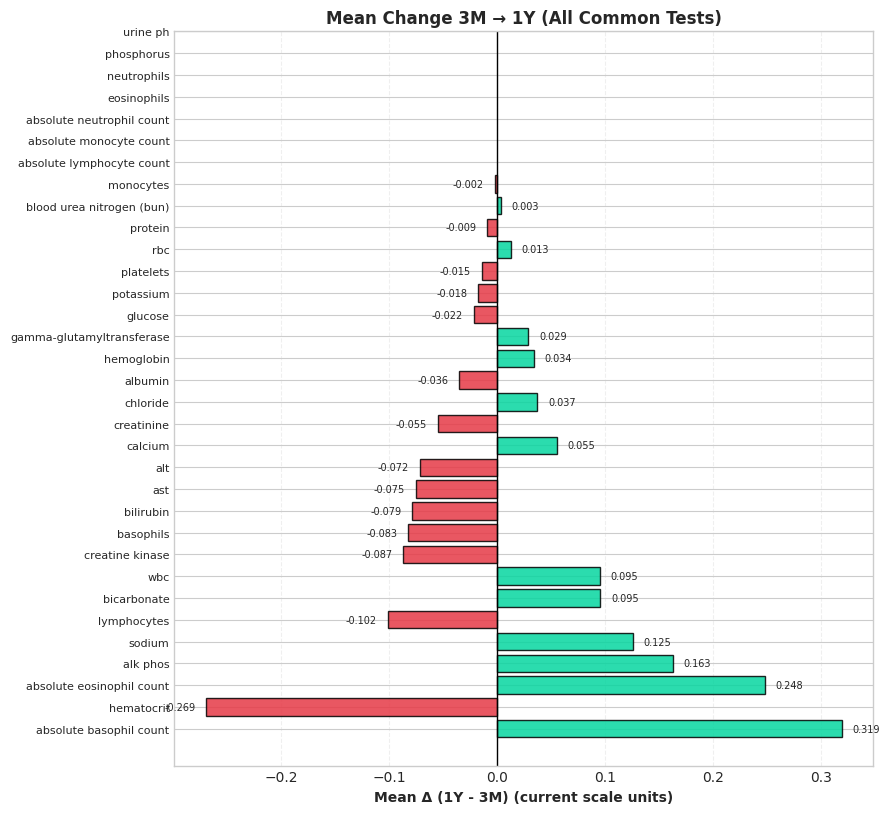

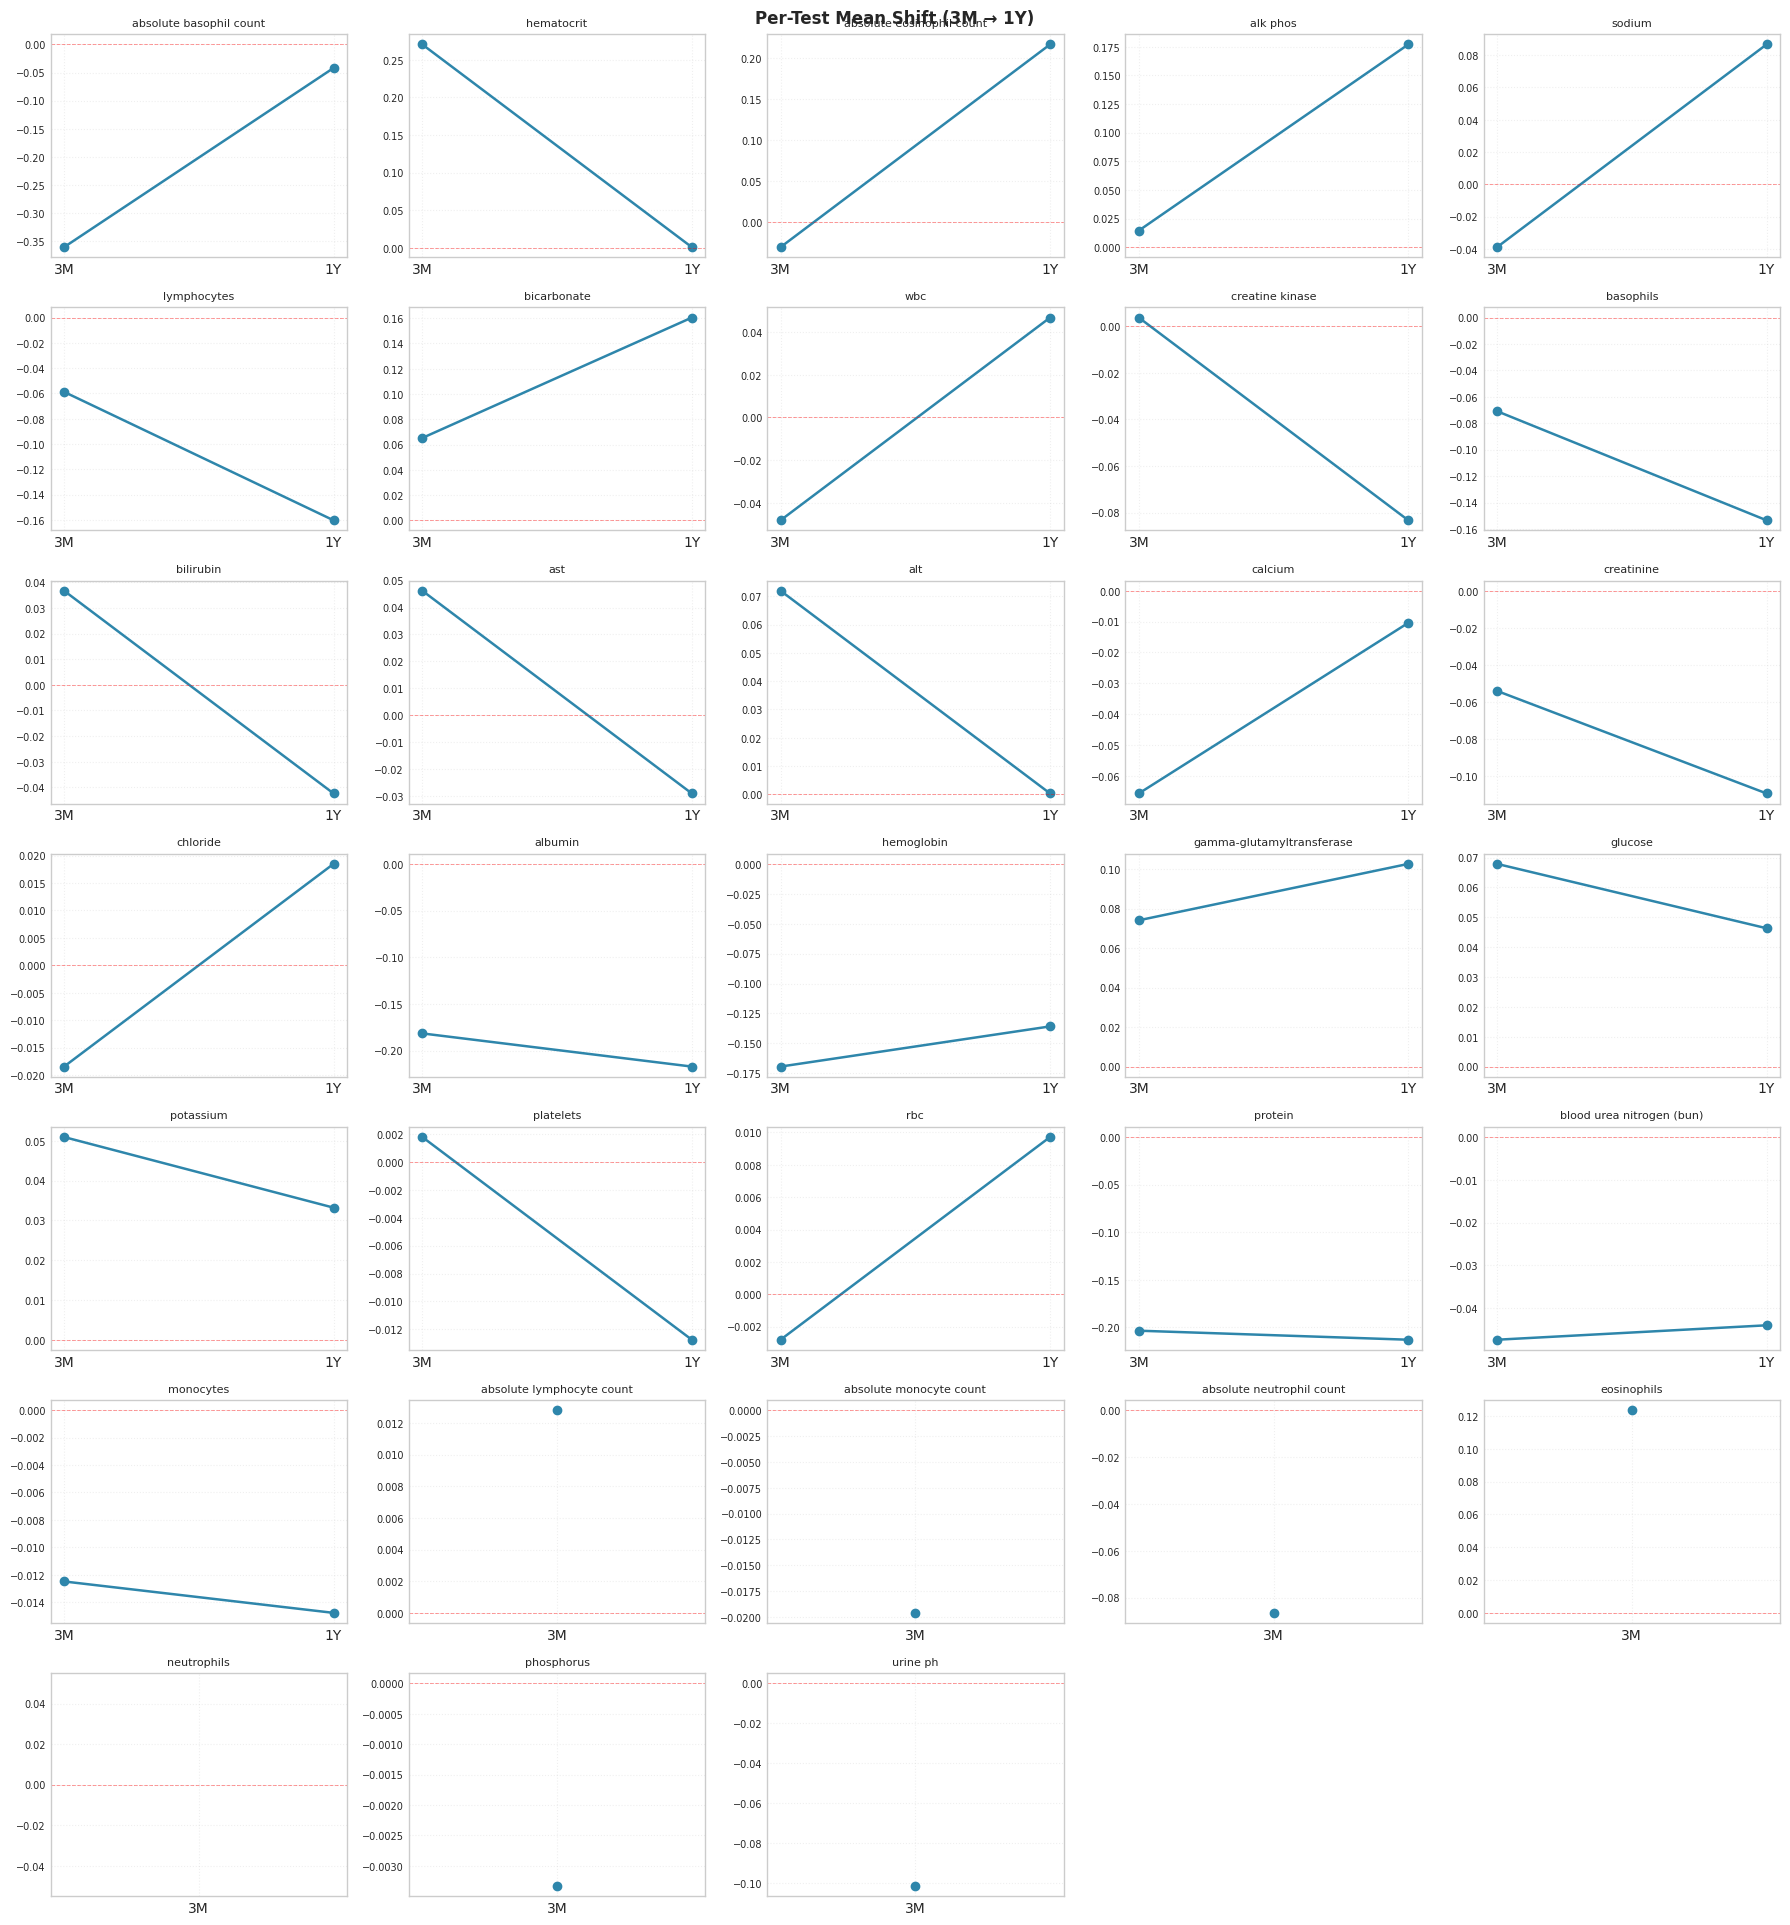

In [32]:
# =============================================================================
# FIXED 3M → 1Y MEAN COMPARISON (PER TEST)
# =============================================================================

# Common test columns excluding subject_id
common_cols = sorted(set(df_3month.columns) & set(df_1year.columns) - {'subject_id'})

rows = []
for col in common_cols:
    v3 = pd.to_numeric(df_3month[col], errors='coerce')
    v1 = pd.to_numeric(df_1year[col], errors='coerce')
    m3 = v3.mean()
    m1 = v1.mean()
    n3 = v3.notna().sum()
    n1 = v1.notna().sum()
    # Paired overlap for subjects with data at both timepoints
    s3 = df_3month[['subject_id', col]].dropna()
    s1 = df_1year[['subject_id', col]].dropna()
    overlap = s3.merge(s1, on='subject_id', suffixes=('_3m', '_1y'))
    n_pair = len(overlap)
    delta = m1 - m3
    rows.append((col, m3, m1, delta, n3, n1, n_pair))

summary = (pd.DataFrame(rows, columns=['Test','Mean_3M','Mean_1Y','Delta_1Y_minus_3M',
                                      'N_3M','N_1Y','N_Paired'])
           .sort_values('Delta_1Y_minus_3M', key=lambda s: s.abs(), ascending=False))

print(f"Total common tests: {len(summary)}")
print(summary.head(15).to_string(index=False))

# =========================
# HORIZONTAL BAR (ABS SORTED Δ)
# =========================
tests = summary['Test'].tolist()
deltas = summary['Delta_1Y_minus_3M'].tolist()
colors = ['#E63946' if d < 0 else '#06D6A0' for d in deltas]

fig, ax = plt.subplots(figsize=(9, max(4, len(tests)*0.25)))
y = np.arange(len(tests))
ax.barh(y, deltas, color=colors, edgecolor='black', alpha=0.85)
ax.axvline(0, color='black', linewidth=1)
for yi, d in zip(y, deltas):
    ax.text(d + (0.01 if d >= 0 else -0.01), yi, f"{d:.3f}",
            va='center', ha='left' if d >= 0 else 'right', fontsize=7)
ax.set_yticks(y)
ax.set_yticklabels(tests, fontsize=8)
ax.set_xlabel("Mean Δ (1Y - 3M) (current scale units)", fontweight='bold')
ax.set_title("Mean Change 3M → 1Y (All Common Tests)", fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# =========================
# PAIRWISE LINE PANEL (OPTIONAL)
# =========================
cols = 5
n = len(tests)
rows_grid = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows_grid, cols, figsize=(3.6*cols, 2.8*rows_grid))
axes = axes.flatten()

for i, test in enumerate(tests):
    ax = axes[i]
    m3 = summary.loc[summary['Test'] == test, 'Mean_3M'].values[0]
    m1 = summary.loc[summary['Test'] == test, 'Mean_1Y'].values[0]
    ax.plot(['3M','1Y'], [m3, m1], marker='o', linewidth=1.8, color='#2E86AB')
    ax.axhline(0, color='red', linestyle='--', linewidth=0.7, alpha=0.4)
    ax.set_title(test, fontsize=8)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(alpha=0.3, linestyle=':')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Per-Test Mean Shift (3M → 1Y)", fontweight='bold')
plt.tight_layout()
plt.show()

# =========================
# SAVE (UNCOMMENT IF NEEDED)
# =========================
# summary.to_csv("mean_change_3m_1y_summary.csv", index=False)
# =============================================================================

In [33]:
# =============================================================================
# UNIT VERIFICATION, NORMALIZATION & OUTLIER DIAGNOSTICS (ENHANCED)
# =============================================================================
print("="*100)
print("UNIT VERIFICATION (Normalized Test Names)")
print("="*100)

# Ensure normalized column exists
if 'Test_Name_Normalized' not in df_labs.columns:
    raise ValueError("Missing Test_Name_Normalized in df_labs. Run normalization cell first.")

baseline_tests = [c for c in df_baseline.columns if c != 'subject_id']

# Filter original rows matching baseline (by normalized name)
unit_check = df_labs[df_labs['Test_Name_Normalized'].isin(baseline_tests)][
    ['Test_Name_Normalized','Test_Unit','Test_Result']
].copy()

unit_check['Test_Result'] = pd.to_numeric(unit_check['Test_Result'], errors='coerce')

# Aggregate per normalized test + unit
unit_stats = (
    unit_check
    .groupby(['Test_Name_Normalized','Test_Unit'], dropna=False)
    .agg(
        Count=('Test_Result','count'),
        Min=('Test_Result','min'),
        Q1=('Test_Result',lambda s: s.quantile(0.25)),
        Median=('Test_Result','median'),
        Q3=('Test_Result',lambda s: s.quantile(0.75)),
        Max=('Test_Result','max'),
        Mean=('Test_Result','mean'),
        Std=('Test_Result','std')
    ).reset_index()
)

print("\nRAW UNIT DISTRIBUTIONS:")
print(unit_stats.sort_values(['Test_Name_Normalized','Count'], ascending=[True,False]).to_string(index=False))

# Detect tests with >1 unit
multi_unit = (
    unit_stats.groupby('Test_Name_Normalized')['Test_Unit']
    .nunique()
    .loc[lambda s: s > 1]
)

print("\n" + "="*100)
print("MULTI-UNIT TESTS (Need Harmonization)")
print("="*100)
if len(multi_unit):
    for test in multi_unit.index:
        subset = unit_stats[unit_stats['Test_Name_Normalized']==test].sort_values('Count', ascending=False)
        print(f"\n{test}:")
        total = subset['Count'].sum()
        for _, r in subset.iterrows():
            pct = 100 * r['Count']/total
            print(f"  • {r['Test_Unit'] or 'None'}: {r['Count']} ({pct:.1f}%)")
else:
    print("✅ No tests with multiple units detected (normalized view).")

# Reference ranges (normalized names)
reference_ranges = {
    'alt': {'U/L': (7,56)},
    'ast': {'U/L': (10,40)},
    'creatinine': {'mg/dL': (0.7,1.3), 'umol/L': (62,115), 'µmol/L': (62,115)},
    'glucose': {'mg/dL': (70,100), 'mmol/L': (3.9,5.6)},
    'sodium': {'mmol/L': (136,145),'mEq/L':(136,145)},
    'potassium': {'mmol/L': (3.5,5.0),'mEq/L':(3.5,5.0)},
    'wbc': {'10^9/L': (4.5,11.0),'K/uL':(4.5,11.0),'10^3/uL':(4.5,11.0)},
    'hemoglobin': {'g/dL': (13.5,17.5),'g/L': (135,175)},
    'platelets': {'10^9/L': (150,400),'K/uL':(150,400),'10^3/uL':(150,400)}
}

# Helper to pick dominant unit
dominant_unit_map = {}
for test in baseline_tests:
    rows = unit_stats[unit_stats['Test_Name_Normalized']==test]
    if len(rows):
        dominant_unit = rows.sort_values('Count', ascending=False)['Test_Unit'].iloc[0]
        dominant_unit_map[test] = dominant_unit

# Optional conversion stubs (extend as needed)
def convert_value(value, src_unit, dst_unit, test):
    if pd.isna(value):
        return np.nan
    # Creatinine μmol/L → mg/dL (divide by 88.4)
    if test == 'creatinine':
        if src_unit in ['umol/L','µmol/L'] and dst_unit == 'mg/dL':
            return value / 88.4
        if src_unit == 'mg/dL' and dst_unit in ['umol/L','µmol/L']:
            return value * 88.4
    # Glucose mg/dL → mmol/L (divide by 18)
    if test == 'glucose':
        if src_unit == 'mg/dL' and dst_unit == 'mmol/L':
            return value / 18.0
        if src_unit == 'mmol/L' and dst_unit == 'mg/dL':
            return value * 18.0
    return value  # no conversion

# Build harmonized baseline (original raw values) dictionary
harmonized_baseline = {}
for test in baseline_tests:
    col = f"{test}_0_baseline"
    if col not in df_wide.columns:
        continue
    raw_vals = pd.to_numeric(df_wide[col], errors='coerce')
    unit = dominant_unit_map.get(test, None)
    ref = reference_ranges.get(test, {})
    # Compute reference-based outliers if unit matches
    if unit in ref:
        ref_min, ref_max = ref[unit]
        outlier_ref = ((raw_vals < ref_min) | (raw_vals > ref_max)).sum()
    else:
        outlier_ref = np.nan
    # IQR outliers (Tukey fences)
    q1, q3 = raw_vals.quantile(0.25), raw_vals.quantile(0.75)
    iqr = q3 - q1
    low_fence, high_fence = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_iqr = ((raw_vals < low_fence) | (raw_vals > high_fence)).sum()
    harmonized_baseline[test] = {
        'unit': unit,
        'count': raw_vals.notna().sum(),
        'min': raw_vals.min(),
        'median': raw_vals.median(),
        'max': raw_vals.max(),
        'mean': raw_vals.mean(),
        'iqr_outliers': int(outlier_iqr),
        'ref_outliers': outlier_ref
    }

print("\n" + "="*100)
print("BASELINE DISTRIBUTIONS & OUTLIERS (Dominant Unit)")
print("="*100)
print(f"{'Test':<28} {'Unit':<10} {'N':<6} {'Min':<10} {'Median':<10} {'Max':<10} {'Mean':<10} {'IQR_Out':<9} {'Ref_Out':<8}")
print("-"*110)
for test, info in sorted(harmonized_baseline.items()):
    print(f"{test:<28} {str(info['unit']):<10} {info['count']:<6} "
          f"{info['min']:<10.2f} {info['median']:<10.2f} {info['max']:<10.2f} "
          f"{info['mean']:<10.2f} {info['iqr_outliers']:<9} {str(info['ref_outliers']):<8}")

print("\n" + "="*100)
print("HARMONIZATION SUGGESTIONS")
print("="*100)
for test in multi_unit.index:
    units_present = unit_stats[unit_stats['Test_Name_Normalized']==test]['Test_Unit'].tolist()
    dom = dominant_unit_map.get(test)
    print(f"• {test}: convert all secondary units -> {dom}. Present: {units_present}")

print("\nNOTES:")
print("  - Multi-unit tests should be converted before modeling.")
print("  - Use dominant unit as target; extend convert_value() for more analytes.")
print("  - ref_outliers = outside clinical range if mapped; NaN means no range.")
print("  - iqr_outliers = Tukey fence outliers (robust statistical).")
# =============================================================================

UNIT VERIFICATION (Normalized Test Names)

RAW UNIT DISTRIBUTIONS:
     Test_Name_Normalized     Test_Unit  Count           Min            Q1        Median          Q3          Max         Mean          Std
  absolute basophil count        10E9/L  59569      0.000000      0.020000      0.040000      0.0600 7.590000e+03 2.927498e+02 1.144563e+03
  absolute basophil count   0.0-0.3K/uL      1      0.040000      0.040000      0.040000      0.0400 4.000000e-02 4.000000e-02          NaN
absolute eosinophil count        10E9/L  61912      0.000000      0.082445      0.133165      0.2300 2.970000e+01 3.946158e-01 1.032118e+00
absolute eosinophil count             %      1      0.100000      0.100000      0.100000      0.1000 1.000000e-01 1.000000e-01          NaN
absolute lymphocyte count        10E9/L  56156      0.000770      1.330000      1.677960      2.0800 1.092000e+03 1.765431e+00 4.640796e+00
  absolute monocyte count        10E9/L  56122      0.000000      0.310000      0.400000     

In [37]:
# =============================================================================
# BASELINE RAW VALUE SUMMARY (RESILIENT – FIX FOR NoneType FORMAT ERROR)
# =============================================================================
import pandas as pd
import numpy as np

def num(x):
    """Return a safely formatted numeric string (or 'NaN')."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "NaN"
    try:
        return f"{float(x):.2f}"
    except Exception:
        return "NaN"

# Verify inputs
if 'df_wide' not in globals() or 'df_baseline' not in globals():
    raise RuntimeError("Required dataframes df_wide / df_baseline missing.")

baseline_tests = [c for c in df_baseline.columns if c != 'subject_id']

# Build unit map robustly
if 'unit_stats' in globals() and {'Test_Name','Test_Unit'}.issubset(unit_stats.columns):
    test_unit_map = (unit_stats.sort_values('Count', ascending=False)
                               .groupby('Test_Name')['Test_Unit']
                               .first()
                               .to_dict())
else:
    # Fallback minimal unit map
    name_field = 'Test_Name_Normalized' if 'Test_Name_Normalized' in df_labs.columns else 'Test_Name'
    tmp_units = df_labs[df_labs[name_field].isin(baseline_tests)][[name_field,'Test_Unit']].dropna()
    test_unit_map = tmp_units.groupby(name_field)['Test_Unit'].agg(lambda s: s.value_counts().idxmax()).to_dict()

print(f"\n{'Test':<30} {'Unit':<12} {'N':<6} {'Min':<8} {'Q1':<8} {'Median':<8} {'Q3':<8} {'Max':<8} {'Mean':<8} {'Std':<8} {'IQR_Out':<8} {'Pct_IQR':<8}")
print("-"*130)

rows = []
warnings = []
for test in baseline_tests:
    raw_col = f"{test}_0_baseline"
    if raw_col not in df_wide.columns:
        continue
    vals = pd.to_numeric(df_wide[raw_col], errors='coerce')
    vals = vals.dropna()
    if vals.empty:
        continue

    unit = test_unit_map.get(test, 'Unknown')

    # Compute robust stats with safeguards
    try:
        vmin  = vals.min()
        vmed  = vals.median()
        vmax  = vals.max()
        vmean = vals.mean()
        vstd  = float(vals.std()) if not np.isnan(vals.std()) else np.nan
        q1 = float(vals.quantile(0.25))
        q3 = float(vals.quantile(0.75))
    except Exception as e:
        warnings.append(f"{test}: stat error {e}")
        vmin=vmed=vmax=vmean=vstd=q1=q3=np.nan

    iqr = q3 - q1 if (not np.isnan(q3) and not np.isnan(q1)) else np.nan
    if not np.isnan(iqr) and iqr > 0:
        low_fence = q1 - 1.5*iqr
        high_fence = q3 + 1.5*iqr
        iqr_out = int(((vals < low_fence) | (vals > high_fence)).sum())
    else:
        low_fence = high_fence = np.nan
        iqr_out = 0
    pct_iqr = (iqr_out / len(vals) * 100) if len(vals) else 0.0

    rows.append({
        'Test': test,
        'Unit': unit,
        'N': len(vals),
        'Min': vmin,
        'Q1': q1,
        'Median': vmed,
        'Q3': q3,
        'Max': vmax,
        'Mean': vmean,
        'Std': vstd,
        'IQR_Outliers': iqr_out,
        'Pct_IQR_Outliers': pct_iqr
    })

    print(f"{test:<30} {str(unit):<12} {len(vals):<6} {num(vmin):<8} {num(q1):<8} {num(vmed):<8} "
          f"{num(q3):<8} {num(vmax):<8} {num(vmean):<8} {num(vstd):<8} {iqr_out:<8} {num(pct_iqr):<8}")

baseline_summary_df = pd.DataFrame(rows)

if warnings:
    print("\nWarnings:")
    for w in warnings:
        print("  -", w)

# Optional save:
# baseline_summary_df.to_csv("baseline_raw_summary.csv", index=False)
# =============================================================================


Test                           Unit         N      Min      Q1       Median   Q3       Max      Mean     Std      IQR_Out  Pct_IQR 
----------------------------------------------------------------------------------------------------------------------------------
absolute basophil count        10E9/L       4821   0.00     0.02     0.04     0.07     6070.00  575.75   1562.32  642      13.32   
absolute eosinophil count      10E9/L       4942   0.00     0.08     0.13     0.23     17.00    0.35     0.75     692      14.00   
absolute lymphocyte count      10E9/L       4248   0.00     1.35     1.67     2.05     9.74     1.74     0.61     139      3.27    
absolute monocyte count        10E9/L       4248   0.00     0.31     0.41     0.52     1.62     0.43     0.17     92       2.17    
absolute neutrophil count      10E9/L       4249   0.00     3.42     4.27     5.30     17.11    4.47     1.54     115      2.71    
albumin                        g/L          5977   19.00    42.00    44.00  

<Axes: xlabel='column_name', ylabel='column_name'>

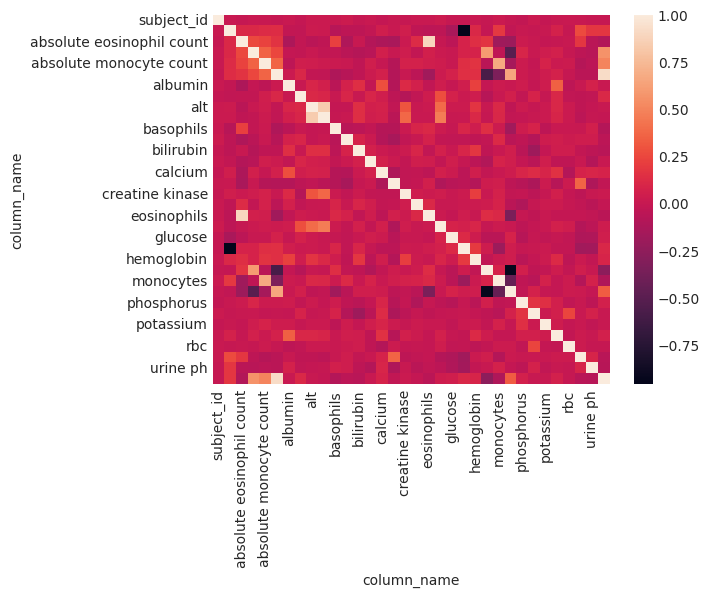

In [38]:
sns.heatmap(df_baseline.corr())